In [162]:
import math
import numpy as np
import matplotlib.pyplot as plt
import torch
import random

%matplotlib inline

In [163]:
# Value Object for our neural net graph

class Value:
    def __init__(self, data, _children=(), _op='', label='') -> None:
        self.data = data
        self.grad = 0.0
        self.label = label
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
    
    def __repr__(self) -> str:
        return f"Value(data={self.data})"
    
    def __add__(self, other) -> 'Value': # self + other
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')
        
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad

        out._backward = _backward
    
        return out
    
    def __mul__(self, other) -> 'Value': # self * other
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')
        
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad

        out._backward = _backward

        return out
    
    def __pow__(self, other) -> 'Value': # self ** other
        assert isinstance(other, (int, float)), "only supports int/float powers"
        out = Value(self.data**other, (self, ), f'**{other}')

        def _backward():
            self.grad += other * (self.data**(other-1)) * out.grad

        out._backward = _backward

        return out
    
    def exp(self) -> 'Value': # e ** self
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')

        def _backward():
            self.grad += out.data * out.grad # becuase derivative of e^x = e^x

        out._backward = _backward

        return out

    def tanh(self) -> 'Value':
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t, (self, ), 'tanh')

        def _backward():
            self.grad += (1 - t**2) * out.grad

        out._backward = _backward

        return out
    
    def __truediv__(self, other) -> 'Value': # self / other
        return self * other**-1
    
    def __sub__(self, other) -> 'Value': # self - other
        return self + (-other)
    
    def __neg__(self) -> 'Value': # -self
        return self * -1
    
    def __radd__(self, other) -> 'Value': # other + self
        return self + other
    
    def __rmul__(self, other) -> 'Value': # other * self
        return self * other
    
    def __rtruediv__(self, other): # other / self
        return other * self**-1
    
    def backward(self) -> None:
        topo: list[Value] = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)

        build_topo(self)
        self.grad = 1.0
        for node in reversed(topo):
            node._backward()



In [164]:
# helper function for graphing NN

from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

![Artifical Neuron](./resources/artificial-neuron.webp)

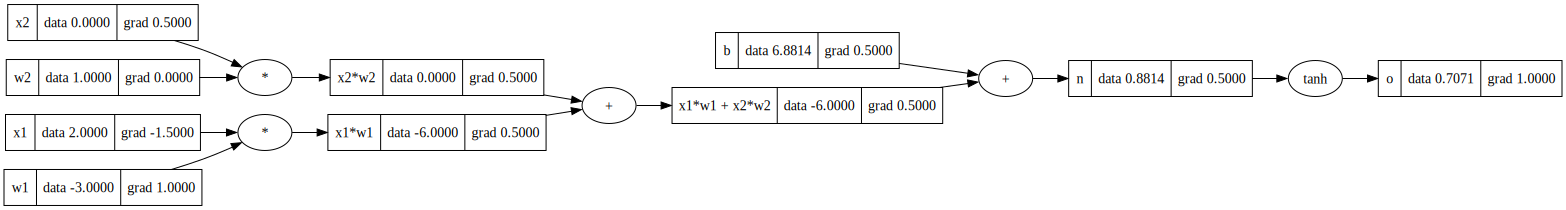

In [165]:
# Single Neuron

# inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights (synaptic strength, scales the related input)
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias of neuron itself, how much it wants to encourage or supress activation
# (bias was arbitrarily chosen to give us near-integer values)
b = Value(6.8813735870195432, label='b')

# computational graph for this neuron ie sum_all(xn * wn)
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
sum_all_inputs = x1w1 + x2w2; sum_all_inputs.label = 'x1*w1 + x2*w2'
n = sum_all_inputs + b; n.label = 'n'

# activation function will determine if it fires or not, so say, only if positive
o = n.tanh(); o.label = 'o'

o.backward()

draw_dot(o)

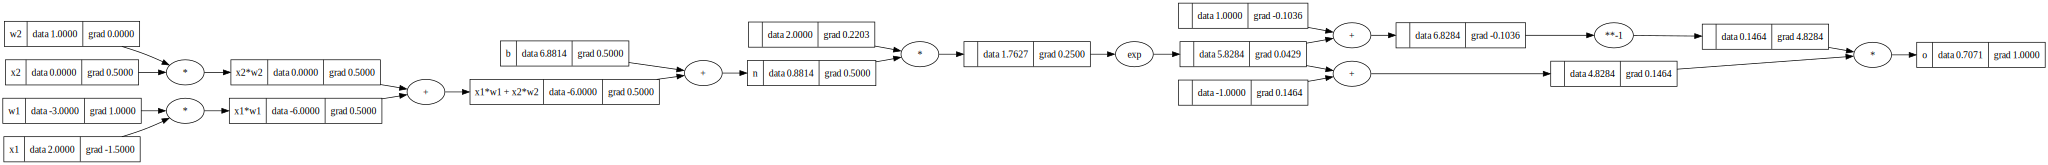

In [166]:
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
b = Value(6.8813735870195432, label='b')
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
sum_all_inputs = x1w1 + x2w2; sum_all_inputs.label = 'x1*w1 + x2*w2'
n = sum_all_inputs + b; n.label = 'n'

# let's test new ops by computing tanh explicitly
# tanh(x) = (exp(2 * x) - 1) / (exp(2 * x) + 1)
e = (2*n).exp()
o = (e-1)/(e+1)

o.label = 'o'

o.backward()

draw_dot(o)

In [167]:
# can do the same thing in pytorch now that we understand how it works

x1 = torch.Tensor([2.0]).double()                ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()                ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()               ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()                ; w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double()  ; b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('---')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

0.7071066904050358
---
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


![MLP](./resources/multi-layer-perceptron.png)

In [168]:
# we built an artificial neuron using Values, so let's now make an official
# Neuron class but utilizing pytorch for the low-level ops

class Neuron:

    def __init__(self, nin) -> None:
        # list of randomized weights, based on input nin (# inputs)
        self.w = [Value(random.uniform(-1, 1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1, 1))

    def __call__(self, x):
        # w * x + b
        act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
        out = act.tanh()
        return out
    
class Layer:

    def __init__(self, nin, nout) -> None:
        self.neurons = [Neuron(nin) for _ in range(nout)]

    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs
    
class MLP:

    def __init__(self, nin, nouts) -> None:
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
            return x

In [169]:
# testing Neuron

x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
n(x)



[Value(data=-0.6674697452841583),
 Value(data=0.9984249187315641),
 Value(data=-0.9710515011961804),
 Value(data=-0.9655938787384529)]